In [17]:
%matplotlib inline

# 假照片製造機

![md_images](Images/gan.jpg)

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import pylab
import PIL
from PIL import Image
import os
import glob
import time
import threading
import random
import math
import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


In [19]:
img_h = 128
img_w = 128
img_c = 3


def img2array(img: Image):
    arr = np.array(img).astype(np.float32)
    arr=arr.transpose(2, 0, 1) #轉成CHW
    arr=arr[::-1] #顏色排序為BGR
    return np.ascontiguousarray(arr)

def array2img(arr: np.ndarray):
    sanitized_img =arr[::-1]#轉成RGB
    sanitized_img = np.maximum(0, np.minimum(255, np.transpose(arr, (1, 2, 0))))#轉成HWC
    img = Image.fromarray(sanitized_img.astype(np.uint8))
    return img



#產生噪音
def noise_sample(num_samples, g_input_dim=100):
    return np.random.uniform(
        low=-1.0,
        high=1.0,
        size=[num_samples, g_input_dim]
    ).astype(np.float32)

s =  glob.glob('resized_images/' + '*.jpg')
print('{0}張圖片'.format(len(s)))
random.shuffle(s)
idx = 0

1629張圖片


In [20]:
def next_minibatch(minibatch_size):
    global s, idx
    features = []
    while len(features) < minibatch_size:
        try:
            im = Image.open(s[idx]).convert('RGB') 
            minibatch_x = img2array(im).astype(np.float32)
            features.append((minibatch_x-127.5) /127.5)
        except OSError as e:
            print(e)
        idx += 1
        if idx >= len(s):
            random.shuffle(s)
            idx = 0
    return np.asarray(features)

In [21]:
def weights_init(m): 
    if isinstance(m, nn.Conv2d): 
        nn.init.kaiming_uniform_(m.weight) 
        m.bias.data.zero_() 

class generator(nn.Module):
    def __init__(self, input_dim=100,input_size=128):
        super(generator, self).__init__()
        self.input_dim=input_dim
        self.input_size=input_size
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 256 * (self.input_size//  32) * (self.input_size//  32)),
            nn.BatchNorm1d(256 * (self.input_size //  32) * (self.input_size //  32)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32,3, 4, 2, 1),
            nn.Tanh(),
        )


    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 256, (self.input_size// 32), (self.input_size// 32))
        x = self.deconv(x)

        return x

class discriminator(nn.Module):

    def __init__(self,output_dim=1,output_size=128):
        super(discriminator, self).__init__()
        self.output_dim=output_dim
        self.output_size=output_size
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 192, 4, 2, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.2),
            nn.Conv2d(192,256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * (self.output_size // 32) * (self.output_size// 32), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,self.output_dim),
        )

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 256 * (self.output_size// 32) * (self.output_size // 32))
        x = self.fc(x)

        return x



In [22]:
def tile_rgb_images(x, row=2, col=2):
    fig = pylab.gcf()
    fig.set_size_inches(col * 2, row * 2)
    pylab.clf()
    pylab.ioff()
    for m in range(row * col):
        pylab.subplot(row, col, m + 1)
        img = array2img(x[m] *127.5+127.5)
        pylab.imshow(img, interpolation="nearest", animated=True)
        pylab.axis("off")
    filename='Results/RaSGAN_pytorch_{}.png'.format(
    str(datetime.datetime.fromtimestamp(time.time())).replace(' ', '').replace(':', '').replace('-', '').replace(
        '.', ''))
    pylab.savefig(filename, bbox_inches='tight')
    img = Image.open(filename)
    plt.axis('off')
    plt.imshow(img)

In [23]:
G = generator(100,128)
D = discriminator(1,128)
if os.path.exists('Models/G_pytorch.cnn'):
    G=torch.load('Models/G_pytorch.cnn')
    print('G recovered!!')
    
if os.path.exists('Models/D_pytorch.cnn'):
    model=torch.load('Models/D_pytorch.cnn')
    print('D recovered!!')
    
G.apply(weights_init)
D.apply(weights_init)
G_optimizer = optim.Adam(G.parameters(), lr=2e-4, weight_decay=1e-4)
D_optimizer = optim.Adam(D.parameters(), lr=2e-4, weight_decay=1e-4)

#self.G.cuda()
#self.D.cuda()

G recovered!!
D recovered!!


epoch start
Epoch: 1/2  Step: 0  D Loss: 1.4209... G Loss: 1.4303...
Epoch: 1/2  Step: 1  D Loss: 1.3738... G Loss: 1.4106...
Epoch: 1/2  Step: 2  D Loss: 1.3907... G Loss: 1.4166...
Epoch: 1/2  Step: 3  D Loss: 1.4182... G Loss: 1.4218...
Epoch: 1/2  Step: 4  D Loss: 1.4191... G Loss: 1.4144...
Epoch: 1/2  Step: 5  D Loss: 1.3759... G Loss: 1.4197...
Epoch: 1/2  Step: 10  D Loss: 1.3954... G Loss: 1.3915...
Epoch: 1/2  Step: 15  D Loss: 1.3722... G Loss: 1.4126...
Epoch: 1/2  Step: 20  D Loss: 1.3760... G Loss: 1.4130...
Epoch: 1/2  Step: 25  D Loss: 1.3698... G Loss: 1.4287...
Epoch: 1/2  Step: 30  D Loss: 1.3353... G Loss: 1.4560...
Epoch: 1/2  Step: 35  D Loss: 1.3506... G Loss: 1.4511...
Epoch: 1/2  Step: 40  D Loss: 1.3214... G Loss: 1.4686...
Epoch: 1/2  Step: 45  D Loss: 1.3381... G Loss: 1.4477...
Epoch: 1/2  Step: 50  D Loss: 1.2824... G Loss: 1.5032...


D:\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1/2  Step: 55  D Loss: 1.2697... G Loss: 1.5279...
Epoch: 1/2  Step: 60  D Loss: 1.2618... G Loss: 1.5377...
Epoch: 1/2  Step: 65  D Loss: 1.2978... G Loss: 1.5083...
Epoch: 1/2  Step: 70  D Loss: 1.3388... G Loss: 1.4756...
Epoch: 1/2  Step: 75  D Loss: 1.1617... G Loss: 1.6634...
Epoch: 1/2  Step: 80  D Loss: 1.1689... G Loss: 1.6417...
Epoch: 1/2  Step: 85  D Loss: 1.0900... G Loss: 1.7662...
Epoch: 1/2  Step: 90  D Loss: 1.1247... G Loss: 1.7681...
Epoch: 1/2  Step: 95  D Loss: 1.2971... G Loss: 1.5252...
Epoch: 2/2  Step: 0  D Loss: 0.9884... G Loss: 1.9356...
Epoch: 2/2  Step: 1  D Loss: 0.9388... G Loss: 2.0459...
Epoch: 2/2  Step: 2  D Loss: 1.2354... G Loss: 1.6309...
Epoch: 2/2  Step: 3  D Loss: 1.0419... G Loss: 1.8174...
Epoch: 2/2  Step: 4  D Loss: 1.0052... G Loss: 1.9242...
Epoch: 2/2  Step: 5  D Loss: 1.0251... G Loss: 1.8787...
Epoch: 2/2  Step: 10  D Loss: 0.9469... G Loss: 2.0014...
Epoch: 2/2  Step: 15  D Loss: 1.1917... G Loss: 1.6632...
Epoch: 2/2  Step: 20

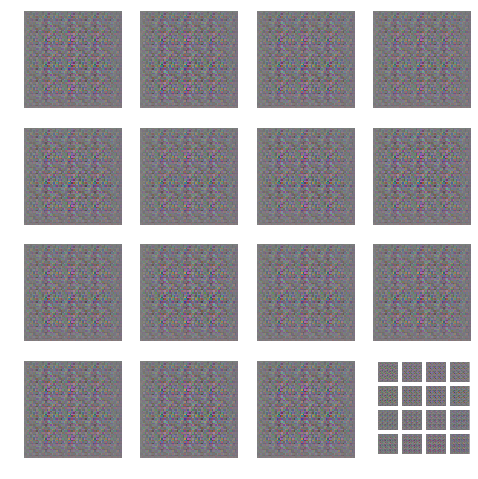

In [24]:
minibatch_size=16
num_epochs=2
print('epoch start')
D.train()
for epoch in range(num_epochs):
    mbs=0
    G.train()
    while mbs <100:
        Z_data = noise_sample(minibatch_size)
        X_data = next_minibatch(minibatch_size)
        
        
        Z_data, X_data = torch.from_numpy(Z_data), torch.from_numpy(X_data)
     
        Z_data, X_data = Variable(Z_data), Variable(X_data)
        #if use_cuda:
        #    Z_data, X_data= inputs.cuda(), targets.cuda()
        # update D network
        D_optimizer.zero_grad()

        D_real = D(X_data)

        G_ = G(Z_data)
        D_fake = D(G_)
        
        epsilon=1e-14
        D_r_tilde = torch.sigmoid(D_real -D_fake.mean())
        D_f_tilde = torch.sigmoid(D_fake - D_real.mean())
        D_loss = - ((D_r_tilde + epsilon).log()).mean() - ((1 - D_f_tilde + epsilon).log()).mean()
        
        #在倒傳導階段是不允許兩個計算圖同時更新梯度，所以要設定retain_graph=True
        D_loss.backward(retain_graph=True)
        D_optimizer.step()

        G_optimizer.zero_grad()

        G_ = G(Z_data)
        D_fake = D(G_)
         
        G_loss =- ((D_f_tilde + epsilon).log()).mean() - ((1 - D_r_tilde + epsilon).log()).mean()
      
        G_loss.backward(retain_graph=True)
        G_optimizer.step()

        if mbs%5==0 or mbs<=5:
            print("Epoch: {}/{} ".format(epoch+1, num_epochs),
                                      "Step: {} ".format(mbs),
                                      "D Loss: {:.4f}...".format(D_loss.data.item()),
                                      "G Loss: {:.4f}...".format(G_loss.data.item()))
        if (mbs % 50 == 0 and mbs > 0):
            tile_rgb_images(G_.detach().numpy(), 4, 4)
            torch.save(G, 'Models/G_pytorch_{0}.cnn'.format(epoch))
            torch.save(G, 'Models/G_pytorch.cnn')
            torch.save(D, 'Models/D_pytorch_{0}.cnn'.format(epoch))
            torch.save(D, 'Models/D_pytorch.cnn')
        mbs+=1

   